<a href="https://colab.research.google.com/github/mherbert93/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/%20DS-Unit-2-Kaggle-Challenge%20/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [28]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [30]:
# Check Pandas Profiling version
import pandas_profiling
import matplotlib
pandas_profiling.__version__

'2.5.0'

In [0]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
#from pandas_profiling import ProfileReport
#profile = ProfileReport(train, minimal=True).to_notebook_iframe()

#profile

In [32]:
train, validation = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=1337)

train.shape, validation.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
target = 'status_group'

y_train = train[target]
y_validation = validation[target]

In [34]:
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

print("Train dataset baseline accuracy is: ", accuracy_score(y_train, y_pred))

Train dataset baseline accuracy is:  0.5430765993265994


In [35]:
y_pred = [majority_class] * len(y_validation)

print("Validation dataset baseline accuracy is: ", accuracy_score(y_validation, y_pred))

Validation dataset baseline accuracy is:  0.5430976430976431


In [36]:
train.shape

(47520, 41)

In [37]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2867
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 287
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2636
recorded_by                  0
scheme_management         3096
scheme_name              22449
permit                    2446
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [0]:
def wrangle(X): #lets clean our data!
    import numpy as np
    from sklearn.cluster import DBSCAN

    X = X.copy()

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    zero_columns = ['population', 'construction_year'] #columns that contain high amount of 0 and should not
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    coords = X[['latitude','longitude']]

    #miles_per_radian = 3959
    #epsilon = 1.0 / miles_per_radian
    #db = DBSCAN(eps=epsilon, min_samples=4, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    #cluster_labels = db.labels_

    #X['labels'] = cluster_labels

    for col in zero_columns:
        X[col] = X[col].replace(0, np.nan) #set 0 values to null

    def impute_longitude_by_region(row): #bin null longitude into its respective region. Gives us a slighter better guess.
        if row['longitude'] == 0:
            return (X[(X['region'] == row['region']) & (X['longitude'] != 0)].longitude.mean())
        else:
            return row['longitude']


    def impute_latitude_by_region(row): #bin null latitude into its respective region. Gives us a slighter better guess.
        if row['latitude'] == 0:
            return (X[(X['region'] == row['region']) & (X['latitude'] != 0)].latitude.mean())
        else:
            return row['latitude']

    def impute_gpsheight(row): #bin null latitude into its respective region. Gives us a slighter better guess.
        if row['gps_height'] == 0:
            return (X[(X['region'] == row['region']) & (X['gps_height'] != 0)].gps_height.mean())
        else:
            return row['gps_height']

    X['longitude'] = X.apply(impute_longitude_by_region, axis=1)
    X['latitude'] = X.apply(impute_latitude_by_region, axis=1)

    X['gps_height'] = X.apply(impute_gpsheight, axis=1)


    X['years_old'] = X['date_recorded'].dt.year - X['construction_year']
    X['month_recorded'] = X['date_recorded'].dt.month

    #X = X.drop(['quantity_group', 'recorded_by', 'date_recorded', 'wpt_name', 'subvillage', 'extraction_type_group', 'num_private', 'waterpoint_type_group', 'source_type', 'quality_group', 'payment_type', 'management_group', 'extraction_type_class', 'region_code', ], axis=1) #drop recorded by as its a constant. drop quantity_group as its a duplicate column.
    X = X.drop(['quantity', 'recorded_by', 'date_recorded', 'wpt_name', 'subvillage', 'extraction_type', 'waterpoint_type', 'source', 'water_quality', 'payment', 'management', 'extraction_type_class', 'region_code', ], axis=1)

    return X



In [0]:
import numpy as np

train = wrangle(train)
validation = wrangle(validation)
test = wrangle(test)

In [40]:
train[train['region'] == 'Shinyanga'].longitude.mean()

33.24830626625279

In [41]:
train['gps_height'].value_counts()

 1350.298507    3848
 1198.791096    2180
 665.299630      390
 399.426344      195
-13.000000        46
                ... 
 649.000000        1
 2057.000000       1
 2080.000000       1
 2207.000000       1
 2255.000000       1
Name: gps_height, Length: 2407, dtype: int64

In [42]:
train[['longitude', 'region']]

,longitude,region
25131,39.333326,Pwani
32516,39.097514,Dar es Salaam
36050,36.685721,Morogoro
49123,37.271837,Kilimanjaro
43898,33.248306,Shinyanga
...,...,...
35094,34.868542,Singida
18358,35.301744,Manyara
14219,33.664673,Shinyanga
25340,30.658477,Kagera


In [43]:
train.shape

(47520, 30)

In [44]:
train.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,district_code,population,construction_year,years_old,month_recorded
id,1.000000,-0.007622,-0.006112,-0.001659,0.003893,-0.002922,-0.001311,-0.000281,-0.004120,0.004621,0.007180
amount_tsh,-0.007622,1.000000,0.022527,0.014560,-0.048339,0.004342,-0.022235,0.000133,0.004488,-0.006993,-0.033551
gps_height,-0.006112,0.022527,1.000000,-0.586334,0.322088,-0.026979,-0.333007,-0.038961,-0.004831,0.014658,0.208307
longitude,-0.001659,0.014560,-0.586334,1.000000,-0.315004,0.064920,0.255552,-0.100663,0.023926,-0.031201,-0.381927
latitude,0.003893,-0.048339,0.322088,-0.315004,1.000000,0.006884,-0.196265,0.051206,0.037549,-0.015885,0.324088
num_private,-0.002922,0.004342,-0.026979,0.064920,0.006884,1.000000,-0.006064,-0.003186,-0.007606,0.003477,-0.028485
district_code,-0.001311,-0.022235,-0.333007,0.255552,-0.196265,-0.006064,1.000000,0.034556,0.006022,-0.003885,-0.105471
population,-0.000281,0.000133,-0.038961,-0.100663,0.051206,-0.003186,0.034556,1.000000,0.027478,-0.024557,-0.008671
construction_year,-0.004120,0.004488,-0.004831,0.023926,0.037549,-0.007606,0.006022,0.027478,1.000000,-0.996935,0.009194
years_old,0.004621,-0.006993,0.014658,-0.031201,-0.015885,0.003477,-0.003885,-0.024557,-0.996935,1.000000,-0.026019


In [0]:
train_features = train.drop([target, 'id'], axis=1)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()
#categorical_features = cardinality[cardinality <= 5000].index.tolist()
categorical_features = train_features.select_dtypes(exclude='number').nunique().index.tolist()

features = numeric_features + categorical_features

In [0]:
y_train = train[target]
X_train = train[features]
y_validation = validation[target]
X_validation = validation[features]
X_test = test[features]

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.metrics import accuracy_score

train_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('imputer', SimpleImputer(strategy='median')),
                           ('model', DecisionTreeClassifier(min_samples_leaf=8, random_state=1337))])

train_pipeline.fit(X_train, y_train)

y_pred = train_pipeline.predict(X_validation)

train_pred = train_pipeline.predict(X_train)

test_pred = train_pipeline.predict(X_test)
print("Validation accuracy score, with", train_pipeline.named_steps.model.n_features_, "features: ", accuracy_score(y_validation, y_pred), "                    Train accuracy is: ", accuracy_score(y_train, train_pred))

Validation accuracy score, with 28 features:  0.7743265993265993                     Train accuracy is:  0.8541666666666666


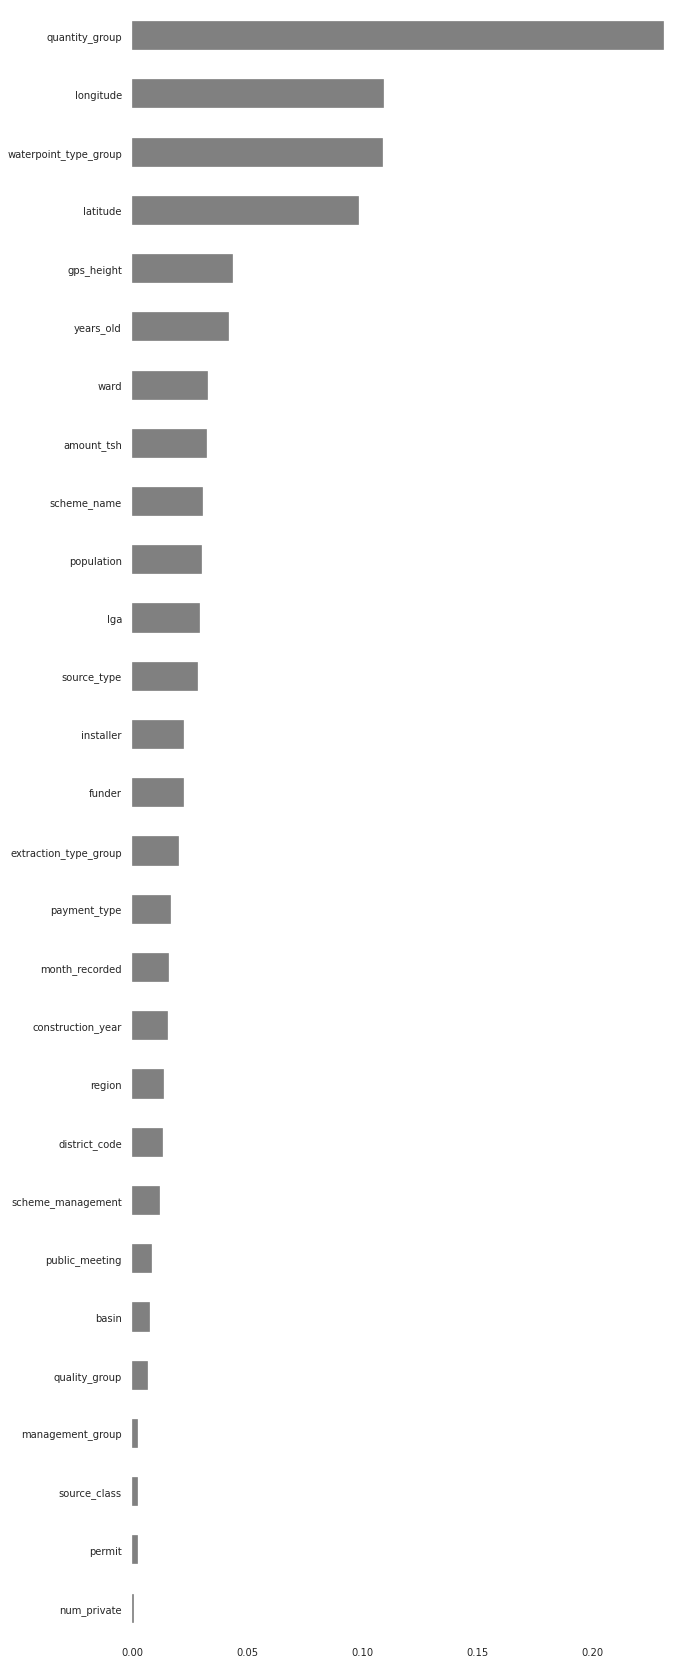

In [48]:
import matplotlib.pyplot as plt


model = train_pipeline.named_steps['model']
encoder = train_pipeline.named_steps['encoder']
encoded_columns = encoder.transform(X_validation).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
submission = sample_submission.copy()
submission['status_group'] = test_pred
submission.to_csv('martin-herbert_decision_tree.csv', index=False)

In [50]:
submission

,id,status_group
0,50785,functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,non functional
14356,33492,functional
